## Dependencies

In [77]:
#Import dependencies

#NFL pbp data
import nfl_data_py as nfl

#Basics / visualizations
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#Machine learning tools
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#Stats Stuff
from scipy import stats
from scipy.stats import t
from scipy.stats import truncnorm

#Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)

#Turn off when showing off, switch comments to change
pd.options.mode.chained_assignment = None  # Disable the warning
# pd.options.mode.chained_assignment = 'warn'

## Importing and Prepping Schedules

In [78]:
schedules_df = nfl.import_schedules([2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

In [79]:
def calculate_implied_totals(df):
    """
    Calculate the implied home and away team totals based on the spread and total lines.
    """
    #Implied totals based on the total and spread lines
    df['implied_home_total'] = (df['total_line'] + df['spread_line']) / 2
    df['implied_away_total'] = (df['total_line'] - df['spread_line']) / 2
    
    return df

In [80]:
schedules_df = calculate_implied_totals(schedules_df)

In [81]:
schedules_df.drop(columns= ['away_coach', 'home_coach', 'referee',
       'stadium_id', 'stadium', 'away_score', 'home_score',
       'location', 'result', 'total', 'overtime', 'old_game_id', 'gsis',
       'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn', 'away_rest', 'home_rest',
       'away_moneyline', 'home_moneyline', 'spread_line', 'away_spread_odds',
       'home_spread_odds', 'total_line', 'under_odds', 'over_odds', 'div_game', 'away_qb_id', 'home_qb_id', 'gameday', 'weekday',
       'gametime'], inplace=True)

In [82]:
#Create a DataFrame for away quarterbacks
away_df = schedules_df[['game_id', 'season', 'game_type', 'week', 'away_team', 'home_team', 'away_qb_name', 'implied_away_total', 'roof', 'surface',]].copy()
away_df.rename(columns={'away_qb_name': 'qb_name', 'implied_away_total': 'implied_total'}, inplace=True)
away_df['home_away'] = 'away'
away_df['posteam'] = away_df['away_team']
away_df['defteam'] = away_df['home_team']

#Create a DataFrame for home quarterbacks
home_df = schedules_df[['game_id', 'season', 'game_type', 'week', 'away_team', 'home_team', 'home_qb_name', 'implied_home_total', 'roof', 'surface']].copy()
home_df.rename(columns={'home_qb_name': 'qb_name', 'implied_home_total': 'implied_total'}, inplace=True)
home_df['home_away'] = 'home'
home_df['posteam'] = home_df['home_team']
home_df['defteam'] = home_df['away_team']

#Concatenate both DataFrames
combined_schedule_df = pd.concat([away_df, home_df])

#Reset index for cleanliness
combined_schedule_df.reset_index(drop=True, inplace=True)

In [83]:
def format_passer_name(qb_name):
    if pd.isna(qb_name):  #Check if the name is NaN
        return ""
    
    name_parts = qb_name.split()
    
    #Extract the first name and last name
    first_name = name_parts[0]
    last_name = name_parts[-1]  # Last name should always be the last part
    
    return f"{first_name[0]}.{last_name}"

#Apply the function to create the new 'player_passer_name' column
combined_schedule_df['passer_player_name'] = combined_schedule_df['qb_name'].apply(format_passer_name)

In [84]:
#Reorder Columns
combined_schedule_df = combined_schedule_df[['game_id', 'season', 'game_type', 'week', 'roof', 'surface',
                                             'posteam', 'defteam', 'home_team', 'away_team', 'qb_name', 'passer_player_name', 'implied_total', 'home_away']]

## Importing PBP Training Data

In [85]:
#Select only the relevant columns
columns = ['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards', 
           'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
           'passing_yards', 'cpoe', 'roof', 'surface']

#Loading in the NFL pbp data
data = nfl.import_pbp_data(range(2014,2024 + 1), columns, include_participation=False)

#nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
data = data[columns]

#Drop all rows that are not a pass
data = data[data['play_type'] == 'pass']

#Drop the play type column
passer_data = data.drop(columns=['play_type'])

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


## Passer DF Training Prep

In [105]:
passer_data.columns

Index(['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week',
       'home_team', 'away_team', 'air_yards', 'yards_after_catch', 'epa',
       'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack',
       'pass_touchdown', 'passing_yards', 'cpoe', 'roof', 'surface'],
      dtype='object')

In [117]:
#Group the data together by passer, week, season and aggregate
passer_df = passer_data.groupby(['game_id', 'posteam', 'week', 'season'], as_index=False).agg(
    {
     'defteam' : 'first',
     'passer_player_name' : 'first',
     'home_team' : 'first',
     'away_team' : 'first',
     'air_yards' : 'sum',
     'yards_after_catch' : 'sum',
     'epa' : 'sum',
     'complete_pass' : 'sum',
     'incomplete_pass' : 'sum',
     'interception' : 'sum',
     'qb_hit' : 'sum',
     'sack' : 'sum',
     'pass_touchdown' : 'sum',
     'passing_yards' : 'sum',
     'cpoe' : 'mean',
     'roof' : 'first',
     'surface' : 'first'
     }
)

#Create a new column that is completion percentage
passer_df['completion_percentage'] = passer_df['complete_pass'] / (passer_df['complete_pass'] + passer_df['incomplete_pass'])

#Create a new column that is the number of pass attempts
passer_df['pass_attempts'] = passer_df['complete_pass'] + passer_df['incomplete_pass']

#Create a new column that equals 1 if the passer is the home team and 0 if the passer is the away team
passer_df['home_flag'] = passer_df['home_team'] == passer_df['posteam']

#Reorder the columns
passer_df = passer_df[['home_team', 'away_team', 'complete_pass', 'incomplete_pass' ,'game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'passing_yards', 'home_flag', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                        'cpoe', 'roof', 'surface']]

In [118]:
# # filtered_with_ewma
# passer_df[(passer_df['posteam'] == 'TEN') & (passer_df['season'] == 2024)].sort_values(by='week')

## Defense DF Training Prep

In [119]:
#Select only the relevant columns
defense_columns = ['defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards',
                   'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
                   'passing_yards', 'cpoe', 'roof', 'surface']


#nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
defense_data = data[defense_columns]

#Drop the play type column
defense_data = defense_data.drop(columns=['play_type'])

#Group the data together by defense, week, and season; then aggregate
defense_df = defense_data.groupby(['defteam', 'week', 'season'], as_index=False).agg(
    {'home_team': 'first',
     'away_team': 'first',
     'air_yards': 'sum',
     'yards_after_catch': 'sum',
     'epa': 'sum',
     'complete_pass': 'sum',
     'incomplete_pass': 'sum',
     'interception': 'sum',
     'qb_hit': 'sum',
     'sack': 'sum',
     'pass_touchdown': 'sum',
     'passing_yards': 'sum',
     'cpoe': 'mean',
     'roof': 'first',
     'surface': 'first'
     }
)

#Create a new column that is completion percentage
defense_df['completion_percentage'] = defense_df['complete_pass'] / (defense_df['complete_pass'] + defense_df['incomplete_pass'])

#Create a new column that is the number of pass attempts
defense_df['pass_attempts'] = defense_df['complete_pass'] + defense_df['incomplete_pass']

#Create a new column that equals 1 if the defense is the home team and 0 if the defense is the away team
defense_df['home_flag'] = defense_df['home_team'] == defense_df['defteam']

#Reorder the columns
defense_df = defense_df[['home_team', 'away_team', 'complete_pass', 'incomplete_pass', 'defteam', 'season', 'week', 'home_flag', 'passing_yards', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                       'cpoe', 'roof', 'surface']]

## Preprocessing, namely exponentially weighted moving averages for offensive and defensive stats to be used as features in train set

In [120]:
def calculate_offensive_ewma(passer_df):
    """
    Calculates EWMA for offensive columns using previous weeks' data, ensuring no leakage by excluding the current week.
    Takes into account multiple seasons.
    """
    #Sort by passer, season, and week
    passer_df = passer_df.sort_values(by=['passer_player_name', 'season', 'week'])

    #Calculate the exponentially weighted moving average for each offensive feature, excluding the current week
    passer_df['completion_percentage_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['completion_percentage']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['pass_attempts_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_attempts']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['air_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['air_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['yards_after_catch_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['yards_after_catch']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['epa_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['epa']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['interception_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['interception']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['qb_hit_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['qb_hit']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['sack_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['sack']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['pass_touchdown_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_touchdown']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['passing_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['passing_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    passer_df['cpoe_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['cpoe']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    return passer_df

In [121]:
def pass_cleaner(passer_df):
    """
    Preps passer df for merging; drops unnecessary columns
    """
    passer_df.drop(columns=['home_team', 'away_team', 'complete_pass', 'incomplete_pass', 'completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'cpoe', 'home_team', 'away_team', 
                                    'complete_pass', 'incomplete_pass'], inplace=True)
    
    return passer_df

In [122]:
passer_emwa = calculate_offensive_ewma(passer_df)

In [123]:
passer_prepped = pass_cleaner(passer_emwa)

In [131]:
passer_prepped[(passer_prepped['posteam'] == 'MIA') & (passer_prepped['season'] == 2024)].sort_values(by='week')

,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag,pass_attempts,roof,surface,completion_percentage_ewma,pass_attempts_ewma,air_yards_ewma,yards_after_catch_ewma,epa_ewma,interception_ewma,qb_hit_ewma,sack_ewma,pass_touchdown_ewma,passing_yards_ewma,cpoe_ewma
5465,2024_01_JAX_MIA,T.Tagovailoa,MIA,JAX,2024,1,338.0,True,37.0,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5485,2024_02_BUF_MIA,T.Tagovailoa,MIA,BUF,2024,2,225.0,True,36.0,outdoors,grass,0.621622,37.000000,228.000000,243.000000,4.323553,0.000000,4.000000,3.000000,1.000000,338.000000,-7.655266
5534,2024_03_MIA_SEA,S.Thompson,MIA,SEA,2024,3,186.0,False,32.0,outdoors,fieldturf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5574,2024_04_TEN_MIA,T.Huntley,MIA,TEN,2024,4,96.0,True,22.0,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5596,2024_05_MIA_NE,T.Huntley,MIA,NE,2024,5,194.0,False,30.0,outdoors,fieldturf,0.636364,22.000000,176.000000,55.000000,-11.762693,0.000000,5.000000,2.000000,0.000000,96.000000,-2.985491
5653,2024_07_MIA_IND,T.Huntley,MIA,IND,2024,7,161.0,False,25.0,closed,fieldturf,0.613636,27.000000,244.750000,65.000000,-6.595653,0.625000,4.375000,2.625000,0.000000,157.250000,-5.378747
5665,2024_08_ARI_MIA,T.Tagovailoa,MIA,ARI,2024,8,234.0,True,38.0,outdoors,grass,0.667136,36.375000,278.625000,186.750000,-8.631067,1.875000,4.625000,2.375000,1.000000,267.375000,-2.577529
5717,2024_09_MIA_BUF,T.Tagovailoa,MIA,BUF,2024,9,231.0,False,28.0,outdoors,a_turf,0.702700,37.204082,234.428571,157.795918,0.227629,0.918367,3.795918,1.673469,1.000000,250.346939,0.718306
5737,2024_10_MIA_LA,T.Tagovailoa,MIA,LA,2024,10,207.0,False,27.0,dome,matrixturf,0.790089,32.974265,189.654412,151.915441,8.185671,0.496324,2.970588,1.363971,1.459559,241.455882,10.169018
5775,2024_11_LV_MIA,T.Tagovailoa,MIA,LV,2024,11,288.0,True,35.0,outdoors,grass,0.768685,30.383067,173.756419,138.506593,3.971183,0.714781,3.417071,2.073560,1.260236,226.511450,4.334002


I need to change my filter from low pass attempts/yards to matching QB name to combined schedules DF. fuck knows how long that's been going on

In [101]:
combined_schedule_df[(combined_schedule_df['home_team'] == 'MIA') & (combined_schedule_df['season'] == 2024) & (combined_schedule_df['week'] == 4)].sort_values(by='week')

,game_id,season,game_type,week,roof,surface,posteam,defteam,home_team,away_team,qb_name,passer_player_name,implied_total,home_away
1986,2024_04_TEN_MIA,2024,REG,4,outdoors,grass,TEN,MIA,MIA,TEN,Will Levis,W.Levis,17.25,away
4195,2024_04_TEN_MIA,2024,REG,4,outdoors,grass,MIA,TEN,MIA,TEN,Tyler Huntley,T.Huntley,19.75,home


In [102]:
# filtered_with_ewma
passer_prepped[(passer_prepped['posteam'] == 'TEN') & (passer_prepped['season'] == 2024)].sort_values(by='week')

,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag,pass_attempts,roof,surface,completion_percentage_ewma,pass_attempts_ewma,air_yards_ewma,yards_after_catch_ewma,epa_ewma,interception_ewma,qb_hit_ewma,sack_ewma,pass_touchdown_ewma,passing_yards_ewma,cpoe_ewma
6673,2024_01_TEN_CHI,W.Levis,TEN,CHI,2024,1,127.0,False,30.0,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6701,2024_02_NYJ_TEN,W.Levis,TEN,NYJ,2024,2,192.0,True,27.0,outdoors,grass,0.633333,30.000000,225.000000,50.000000,-18.171179,2.000000,10.000000,3.000000,1.000000,127.000000,4.881220
6724,2024_03_GB_TEN,W.Levis,TEN,GB,2024,3,260.0,True,32.0,outdoors,grass,0.677315,28.125000,261.875000,70.000000,-10.842541,1.375000,7.500000,3.625000,1.000000,167.625000,6.178396
6789,2024_04_TEN_MIA,W.Levis,TEN,MIA,2024,4,25.0,False,3.0,outdoors,grass,0.746287,30.102041,246.122449,103.163265,-13.973825,1.693878,8.775510,5.857143,1.510204,214.755102,5.934019
6787,2024_04_TEN_MIA,M.Rudolph,TEN,MIA,2024,4,85.0,False,16.0,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6847,2024_06_IND_TEN,W.Levis,TEN,IND,2024,6,95.0,True,26.0,outdoors,grass,0.862883,17.647059,141.286765,61.727941,-8.969667,1.375000,4.742647,3.165441,0.816176,127.551471,2.526561
6901,2024_07_TEN_BUF,M.Rudolph,TEN,BUF,2024,7,215.0,False,38.0,outdoors,a_turf,0.562500,16.000000,68.000000,40.000000,-4.334707,0.000000,3.000000,1.000000,0.000000,85.000000,-5.395733
6942,2024_08_TEN_DET,M.Rudolph,TEN,DET,2024,8,266.0,False,36.0,dome,fieldturf,0.622122,29.750000,166.125000,89.375000,-3.906525,0.625000,7.375000,2.250000,0.625000,166.250000,-3.187775
6973,2024_09_NE_TEN,M.Rudolph,TEN,NE,2024,9,240.0,True,32.0,outdoors,grass,0.616504,32.938776,267.591837,84.081633,-10.651461,1.326531,6.163265,1.612245,0.816327,217.142857,-4.837220
7011,2024_10_TEN_LAC,W.Levis,TEN,LAC,2024,10,175.0,False,23.0,dome,matrixturf,0.755536,21.269951,186.703678,49.701596,-7.544960,1.212353,4.420541,1.792505,0.895906,113.433033,-0.245242


In [18]:
def calculate_defensive_ewma(defense_df):
    """
    Calculates EWMA for defensive columns using previous weeks' data (excluding the current week).
    """
    #Sort by 'defteam', 'season', and 'week' in ascending order (to ensure time order)
    defense_df = defense_df.sort_values(by=['defteam', 'season', 'week'])

    #Ensure proper grouping by both defteam and season
    defense_df['completion_percentage_ewma'] = defense_df.groupby(['defteam', 'season'])['completion_percentage']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())
    
    defense_df['pass_attempts_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_attempts']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    defense_df['air_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['air_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    defense_df['yards_after_catch_ewma'] = defense_df.groupby(['defteam', 'season'])['yards_after_catch']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    defense_df['epa_ewma'] = defense_df.groupby(['defteam', 'season'])['epa']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    defense_df['interception_ewma'] = defense_df.groupby(['defteam', 'season'])['interception']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    defense_df['qb_hit_ewma'] = defense_df.groupby(['defteam', 'season'])['qb_hit']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    defense_df['sack_ewma'] = defense_df.groupby(['defteam', 'season'])['sack']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    defense_df['pass_touchdown_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_touchdown']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    defense_df['passing_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['passing_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    defense_df['cpoe_ewma'] = defense_df.groupby(['defteam', 'season'])['cpoe']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=4).mean())

    return defense_df

In [19]:
def def_cleaner(defense_df):
    """
    Preps passer df for merging; drops unnecessary columns
    """
    #Drop the non-ewma columns
    defense_df.drop(columns=['passing_yards','completion_percentage',
                            'air_yards', 'yards_after_catch', 'epa',     
                            'interception', 'qb_hit', 'sack', 'pass_touchdown', 'pass_attempts', 'cpoe', 'complete_pass', 'incomplete_pass',
                            'home_team', 'away_team'
                            ], inplace=True)
    
    return defense_df

In [20]:
defense_ewma = calculate_defensive_ewma(defense_df)

In [21]:
defense_prepped = def_cleaner(defense_ewma)

In [69]:
#Merge the defense and passer dataframes together|
full_with_ewma = passer_prepped.merge(defense_prepped, how='inner', on=['defteam', 'season', 'week', 'roof', 'surface'], suffixes=('_passer', '_defense'))

In [75]:
passer_prepped

,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag,pass_attempts,roof,surface,completion_percentage_ewma,pass_attempts_ewma,air_yards_ewma,yards_after_catch_ewma,epa_ewma,interception_ewma,qb_hit_ewma,sack_ewma,pass_touchdown_ewma,passing_yards_ewma,cpoe_ewma
1113,2015_14_TEN_NYJ,A.Andrews,TEN,NYJ,2015,14,41.0,False,1.0,outdoors,fieldturf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3730,2019_16_DET_DEN,A.Beck,DEN,DET,2019,16,6.0,True,1.0,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,2014_05_KC_SF,A.Boldin,SF,KC,2014,5,0.0,True,1.0,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,2014_04_TB_PIT,A.Brown,PIT,TB,2014,4,17.0,True,1.0,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,2014_07_HOU_PIT,A.Brown,PIT,HOU,2014,7,3.0,True,1.0,outdoors,grass,1.000000,1.000000,6.000000,11.000000,0.896934,0.000000,0.000000,0.000000,0.000000,17.000000,26.208937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,2023_09_LAC_NYJ,Z.Wilson,NYJ,LAC,2023,9,263.0,True,49.0,outdoors,fieldturf,0.576015,32.708262,253.338355,102.079802,-10.418960,0.263346,7.937923,3.945403,0.640496,212.450552,-8.168615
6286,2023_10_NYJ_LV,Z.Wilson,NYJ,LV,2023,10,263.0,False,38.0,dome,grass,0.615663,39.336282,293.884025,108.556668,-15.920551,0.156208,7.556345,5.594948,0.379921,233.015747,-4.667737
6319,2023_11_NYJ_BUF,Z.Wilson,NYJ,BUF,2023,11,81.0,False,14.0,outdoors,a_turf,0.611461,38.796328,319.791502,124.898691,-11.153561,0.497161,6.523397,4.142330,0.226406,245.131548,-5.584949
6420,2023_14_HOU_NYJ,Z.Wilson,NYJ,HOU,2023,14,301.0,True,36.0,outdoors,fieldturf,0.566605,28.817458,221.681669,98.378859,-10.109015,0.699520,5.910331,4.487485,0.537726,179.079537,-10.461394


In [70]:
full_with_ewma[(full_with_ewma['posteam'] == 'TEN') & (full_with_ewma['season'] == 2024)].sort_values(by='week')

,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag_passer,pass_attempts,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
7306,2024_01_TEN_CHI,W.Levis,TEN,CHI,2024,1,127.0,False,30.0,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7307,2024_02_NYJ_TEN,W.Levis,TEN,NYJ,2024,2,192.0,True,27.0,outdoors,grass,0.633333,30.000000,225.000000,50.000000,-18.171179,2.000000,10.000000,3.000000,1.000000,127.000000,4.881220,False,0.655172,29.000000,282.000000,65.000000,4.411567,0.000000,4.000000,3.000000,0.000000,231.000000,1.223947
7308,2024_03_GB_TEN,W.Levis,TEN,GB,2024,3,260.0,True,32.0,outdoors,grass,0.677315,28.125000,261.875000,70.000000,-10.842541,1.375000,7.500000,3.625000,1.000000,167.625000,6.178396,False,0.596102,30.375000,348.625000,110.000000,-1.009233,2.625000,3.750000,1.375000,1.375000,231.750000,-4.625201
5548,2024_04_TEN_MIA,M.Rudolph,TEN,MIA,2024,4,85.0,False,16.0,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.728949,26.000000,175.285714,111.224490,3.312504,1.020408,4.306122,2.081633,1.000000,219.755102,4.643581
5549,2024_04_TEN_MIA,W.Levis,TEN,MIA,2024,4,25.0,False,3.0,outdoors,grass,0.746287,30.102041,246.122449,103.163265,-13.973825,1.693878,8.775510,5.857143,1.510204,214.755102,5.934019,True,0.728949,26.000000,175.285714,111.224490,3.312504,1.020408,4.306122,2.081633,1.000000,219.755102,4.643581
7309,2024_06_IND_TEN,W.Levis,TEN,IND,2024,6,95.0,True,26.0,outdoors,grass,0.862883,17.647059,141.286765,61.727941,-8.969667,1.375000,4.742647,3.165441,0.816176,127.551471,2.526561,False,0.769117,33.662040,267.624566,165.061763,5.347685,0.746010,3.108258,1.890354,1.646079,323.368494,8.191206
5550,2024_07_TEN_BUF,M.Rudolph,TEN,BUF,2024,7,215.0,False,38.0,outdoors,a_turf,0.562500,16.000000,68.000000,40.000000,-4.334707,0.000000,3.000000,1.000000,0.000000,85.000000,-5.395733,True,0.697865,33.497315,238.450994,135.441058,4.124033,0.925081,5.402793,2.353921,1.570623,266.043367,2.661969
5551,2024_08_TEN_DET,M.Rudolph,TEN,DET,2024,8,266.0,False,36.0,dome,fieldturf,0.622122,29.750000,166.125000,89.375000,-3.906525,0.625000,7.375000,2.250000,0.625000,166.250000,-3.187775,True,0.729923,35.073711,271.771617,110.026584,-9.114791,1.503491,7.068743,3.566192,0.748255,263.887084,2.997658
5552,2024_09_NE_TEN,M.Rudolph,TEN,NE,2024,9,240.0,True,32.0,outdoors,grass,0.616504,32.938776,267.591837,84.081633,-10.651461,1.326531,6.163265,1.612245,0.816327,217.142857,-4.837220,False,0.654934,27.074436,238.537739,77.483956,5.401319,0.287062,3.438026,1.170487,1.632124,219.220797,4.775188
7310,2024_10_TEN_LAC,W.Levis,TEN,LAC,2024,10,175.0,False,23.0,dome,matrixturf,0.755536,21.269951,186.703678,49.701596,-7.544960,1.212353,4.420541,1.792505,0.895906,113.433033,-0.245242,True,0.591902,37.515539,309.331794,79.538676,-11.787897,1.569567,5.960465,4.142216,0.824795,229.605555,-10.254322


In [74]:
combined_schedule_df[(combined_schedule_df['posteam'] == 'TEN') & (combined_schedule_df['season'] == 2024)].sort_values(by='week')

,game_id,season,game_type,week,roof,surface,posteam,defteam,home_team,away_team,qb_name,passer_player_name,implied_total,home_away
1928,2024_01_TEN_CHI,2024,REG,1,outdoors,grass,TEN,CHI,CHI,TEN,Will Levis,W.Levis,19.50,away
4158,2024_02_NYJ_TEN,2024,REG,2,outdoors,grass,TEN,NYJ,TEN,NYJ,Will Levis,W.Levis,19.00,home
4172,2024_03_GB_TEN,2024,REG,3,outdoors,grass,TEN,GB,TEN,GB,Will Levis,W.Levis,20.00,home
1986,2024_04_TEN_MIA,2024,REG,4,outdoors,grass,TEN,MIA,MIA,TEN,Will Levis,W.Levis,17.25,away
4218,2024_06_IND_TEN,2024,REG,6,outdoors,grass,TEN,IND,TEN,IND,Will Levis,W.Levis,22.25,home
2019,2024_07_TEN_BUF,2024,REG,7,outdoors,a_turf,TEN,BUF,BUF,TEN,Mason Rudolph,M.Rudolph,15.75,away
2034,2024_08_TEN_DET,2024,REG,8,dome,fieldturf,TEN,DET,DET,TEN,Mason Rudolph,M.Rudolph,16.25,away
4264,2024_09_NE_TEN,2024,REG,9,outdoors,grass,TEN,NE,TEN,NE,Mason Rudolph,M.Rudolph,20.75,home
2071,2024_10_TEN_LAC,2024,REG,10,dome,matrixturf,TEN,LAC,LAC,TEN,Mason Rudolph,M.Rudolph,16.00,away
4293,2024_11_MIN_TEN,2024,REG,11,outdoors,grass,TEN,MIN,TEN,MIN,Mason Rudolph,M.Rudolph,17.00,home


In [71]:
# Merge full_with_ewma with combined_schedule_df to get the correct starting QB
full_with_ewma = full_with_ewma.merge(
    combined_schedule_df[['game_id', 'posteam', 'passer_player_name']],
    on=['game_id', 'posteam'],
    how='left',
    suffixes=('', '_starter')  # Add suffix to distinguish the real starter
)

# Keep only rows where the passer matches the actual starting QB
filtered_with_ewma = full_with_ewma[full_with_ewma['passer_player_name'] == full_with_ewma['passer_player_name_starter']]

In [73]:
filtered_with_ewma[(filtered_with_ewma['posteam'] == 'TEN') & (filtered_with_ewma['season'] == 2024)].sort_values(by='week')

,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag_passer,pass_attempts,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense,passer_player_name_starter
7306,2024_01_TEN_CHI,W.Levis,TEN,CHI,2024,1,127.0,False,30.0,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W.Levis
7307,2024_02_NYJ_TEN,W.Levis,TEN,NYJ,2024,2,192.0,True,27.0,outdoors,grass,0.633333,30.000000,225.000000,50.000000,-18.171179,2.000000,10.000000,3.000000,1.000000,127.000000,4.881220,False,0.655172,29.000000,282.000000,65.000000,4.411567,0.000000,4.000000,3.000000,0.000000,231.000000,1.223947,W.Levis
7308,2024_03_GB_TEN,W.Levis,TEN,GB,2024,3,260.0,True,32.0,outdoors,grass,0.677315,28.125000,261.875000,70.000000,-10.842541,1.375000,7.500000,3.625000,1.000000,167.625000,6.178396,False,0.596102,30.375000,348.625000,110.000000,-1.009233,2.625000,3.750000,1.375000,1.375000,231.750000,-4.625201,W.Levis
5549,2024_04_TEN_MIA,W.Levis,TEN,MIA,2024,4,25.0,False,3.0,outdoors,grass,0.746287,30.102041,246.122449,103.163265,-13.973825,1.693878,8.775510,5.857143,1.510204,214.755102,5.934019,True,0.728949,26.000000,175.285714,111.224490,3.312504,1.020408,4.306122,2.081633,1.000000,219.755102,4.643581,W.Levis
7309,2024_06_IND_TEN,W.Levis,TEN,IND,2024,6,95.0,True,26.0,outdoors,grass,0.862883,17.647059,141.286765,61.727941,-8.969667,1.375000,4.742647,3.165441,0.816176,127.551471,2.526561,False,0.769117,33.662040,267.624566,165.061763,5.347685,0.746010,3.108258,1.890354,1.646079,323.368494,8.191206,W.Levis
5550,2024_07_TEN_BUF,M.Rudolph,TEN,BUF,2024,7,215.0,False,38.0,outdoors,a_turf,0.562500,16.000000,68.000000,40.000000,-4.334707,0.000000,3.000000,1.000000,0.000000,85.000000,-5.395733,True,0.697865,33.497315,238.450994,135.441058,4.124033,0.925081,5.402793,2.353921,1.570623,266.043367,2.661969,M.Rudolph
5551,2024_08_TEN_DET,M.Rudolph,TEN,DET,2024,8,266.0,False,36.0,dome,fieldturf,0.622122,29.750000,166.125000,89.375000,-3.906525,0.625000,7.375000,2.250000,0.625000,166.250000,-3.187775,True,0.729923,35.073711,271.771617,110.026584,-9.114791,1.503491,7.068743,3.566192,0.748255,263.887084,2.997658,M.Rudolph
5552,2024_09_NE_TEN,M.Rudolph,TEN,NE,2024,9,240.0,True,32.0,outdoors,grass,0.616504,32.938776,267.591837,84.081633,-10.651461,1.326531,6.163265,1.612245,0.816327,217.142857,-4.837220,False,0.654934,27.074436,238.537739,77.483956,5.401319,0.287062,3.438026,1.170487,1.632124,219.220797,4.775188,M.Rudolph
5554,2024_15_CIN_TEN,W.Levis,TEN,CIN,2024,15,89.0,True,9.0,outdoors,grass,0.614380,30.485997,242.220165,96.603434,-4.461957,0.319272,6.013534,3.375839,1.028548,202.028254,-5.304683,False,0.624146,33.059122,260.136165,135.370394,3.125058,0.696365,6.827059,2.342633,2.300887,269.970108,-3.451146,W.Levis
5555,2024_16_TEN_IND,M.Rudolph,TEN,IND,2024,16,252.0,False,31.0,closed,fieldturf,0.730832,28.817488,223.461485,104.930604,2.275578,1.099931,3.794587,0.753643,1.637752,219.559334,6.499437,True,0.725931,30.972685,189.911041,117.625726,-3.103580,1.620810,3.607466,2.358433,1.759368,198.894340,0.392156,M.Rudolph


In [66]:
combined_schedule_df[(combined_schedule_df['posteam'] == 'TEN') & (combined_schedule_df['season'] == 2024)].sort_values(by='week')

,game_id,season,game_type,week,roof,surface,posteam,defteam,home_team,away_team,qb_name,passer_player_name,implied_total,home_away
1928,2024_01_TEN_CHI,2024,REG,1,outdoors,grass,TEN,CHI,CHI,TEN,Will Levis,W.Levis,19.50,away
4158,2024_02_NYJ_TEN,2024,REG,2,outdoors,grass,TEN,NYJ,TEN,NYJ,Will Levis,W.Levis,19.00,home
4172,2024_03_GB_TEN,2024,REG,3,outdoors,grass,TEN,GB,TEN,GB,Will Levis,W.Levis,20.00,home
1986,2024_04_TEN_MIA,2024,REG,4,outdoors,grass,TEN,MIA,MIA,TEN,Will Levis,W.Levis,17.25,away
4218,2024_06_IND_TEN,2024,REG,6,outdoors,grass,TEN,IND,TEN,IND,Will Levis,W.Levis,22.25,home
2019,2024_07_TEN_BUF,2024,REG,7,outdoors,a_turf,TEN,BUF,BUF,TEN,Mason Rudolph,M.Rudolph,15.75,away
2034,2024_08_TEN_DET,2024,REG,8,dome,fieldturf,TEN,DET,DET,TEN,Mason Rudolph,M.Rudolph,16.25,away
4264,2024_09_NE_TEN,2024,REG,9,outdoors,grass,TEN,NE,TEN,NE,Mason Rudolph,M.Rudolph,20.75,home
2071,2024_10_TEN_LAC,2024,REG,10,dome,matrixturf,TEN,LAC,LAC,TEN,Mason Rudolph,M.Rudolph,16.00,away
4293,2024_11_MIN_TEN,2024,REG,11,outdoors,grass,TEN,MIN,TEN,MIN,Mason Rudolph,M.Rudolph,17.00,home


In [52]:
# filtered_with_ewma
filtered_with_ewma[(filtered_with_ewma['posteam'] == 'TEN') & (filtered_with_ewma['season'] == 2024)].sort_values(by='week')

,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag_passer,pass_attempts,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense,passer_player_name_starter
7306,2024_01_TEN_CHI,W.Levis,TEN,CHI,2024,1,127.0,False,30.0,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W.Levis
7307,2024_02_NYJ_TEN,W.Levis,TEN,NYJ,2024,2,192.0,True,27.0,outdoors,grass,0.633333,30.000000,225.000000,50.000000,-18.171179,2.000000,10.000000,3.000000,1.000000,127.000000,4.881220,False,0.655172,29.000000,282.000000,65.000000,4.411567,0.000000,4.000000,3.000000,0.000000,231.000000,1.223947,W.Levis
7308,2024_03_GB_TEN,W.Levis,TEN,GB,2024,3,260.0,True,32.0,outdoors,grass,0.677315,28.125000,261.875000,70.000000,-10.842541,1.375000,7.500000,3.625000,1.000000,167.625000,6.178396,False,0.596102,30.375000,348.625000,110.000000,-1.009233,2.625000,3.750000,1.375000,1.375000,231.750000,-4.625201,W.Levis
5549,2024_04_TEN_MIA,W.Levis,TEN,MIA,2024,4,25.0,False,3.0,outdoors,grass,0.746287,30.102041,246.122449,103.163265,-13.973825,1.693878,8.775510,5.857143,1.510204,214.755102,5.934019,True,0.728949,26.000000,175.285714,111.224490,3.312504,1.020408,4.306122,2.081633,1.000000,219.755102,4.643581,W.Levis
7309,2024_06_IND_TEN,W.Levis,TEN,IND,2024,6,95.0,True,26.0,outdoors,grass,0.862883,17.647059,141.286765,61.727941,-8.969667,1.375000,4.742647,3.165441,0.816176,127.551471,2.526561,False,0.769117,33.662040,267.624566,165.061763,5.347685,0.746010,3.108258,1.890354,1.646079,323.368494,8.191206,W.Levis
5550,2024_07_TEN_BUF,M.Rudolph,TEN,BUF,2024,7,215.0,False,38.0,outdoors,a_turf,0.562500,16.000000,68.000000,40.000000,-4.334707,0.000000,3.000000,1.000000,0.000000,85.000000,-5.395733,True,0.697865,33.497315,238.450994,135.441058,4.124033,0.925081,5.402793,2.353921,1.570623,266.043367,2.661969,M.Rudolph
5551,2024_08_TEN_DET,M.Rudolph,TEN,DET,2024,8,266.0,False,36.0,dome,fieldturf,0.622122,29.750000,166.125000,89.375000,-3.906525,0.625000,7.375000,2.250000,0.625000,166.250000,-3.187775,True,0.729923,35.073711,271.771617,110.026584,-9.114791,1.503491,7.068743,3.566192,0.748255,263.887084,2.997658,M.Rudolph
5552,2024_09_NE_TEN,M.Rudolph,TEN,NE,2024,9,240.0,True,32.0,outdoors,grass,0.616504,32.938776,267.591837,84.081633,-10.651461,1.326531,6.163265,1.612245,0.816327,217.142857,-4.837220,False,0.654934,27.074436,238.537739,77.483956,5.401319,0.287062,3.438026,1.170487,1.632124,219.220797,4.775188,M.Rudolph
5554,2024_15_CIN_TEN,W.Levis,TEN,CIN,2024,15,89.0,True,9.0,outdoors,grass,0.614380,30.485997,242.220165,96.603434,-4.461957,0.319272,6.013534,3.375839,1.028548,202.028254,-5.304683,False,0.624146,33.059122,260.136165,135.370394,3.125058,0.696365,6.827059,2.342633,2.300887,269.970108,-3.451146,W.Levis
5555,2024_16_TEN_IND,M.Rudolph,TEN,IND,2024,16,252.0,False,31.0,closed,fieldturf,0.730832,28.817488,223.461485,104.930604,2.275578,1.099931,3.794587,0.753643,1.637752,219.559334,6.499437,True,0.725931,30.972685,189.911041,117.625726,-3.103580,1.620810,3.607466,2.358433,1.759368,198.894340,0.392156,M.Rudolph


## Week 1 is NaN's (duh, we use past weeks for EWMA's) for MVP I'll just get rid but for future seasons/rookies I do need a strategy

In [21]:
filtered_with_ewma = filtered_with_ewma.dropna()

In [22]:
#Perform the merge based on game_id, season, week, and team
filtered_with_ewma_it = pd.merge(filtered_with_ewma, combined_schedule_df[['game_id', 'season', 'week', 'posteam', 'implied_total']], 
                     on=['game_id', 'season', 'week', 'posteam'], 
                     how='inner')

## Modeling

In [23]:
#Define the target and features
target = 'passing_yards'
features = filtered_with_ewma_it.columns.drop(['pass_attempts', 'passer_player_name', 'passing_yards', 'posteam', 'defteam', 'season', 'week', 'game_id', 'implied_total'])

#Define categorical and numeric columns
categorical_columns = ['roof', 'surface', 'home_flag_passer', 'home_flag_defense']
numeric_columns = [col for col in features if col not in categorical_columns]

#Split the data into training (up to 2023) and testing (2024)
train_data = filtered_with_ewma_it[filtered_with_ewma_it['season'] <= 2023]
test_data = filtered_with_ewma_it[filtered_with_ewma_it['season'] == 2024]

#Separate features and target for both training and testing
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

#Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ])

#Apply the transformations to the training and test sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [24]:
#Initialize the basic XGBoost model
xgb_model_basic = xgb.XGBRegressor(
    n_estimators=142,  # Basic number of boosting rounds
    learning_rate=0.101,  # Standard learning rate
    max_depth=3,        # Typical depth for a basic model
    reg_lambda= 2,      #something something regularization
    random_state=42,    # For reproducibility
    n_jobs=-1           # Use all CPU cores for faster training
)

#Train the model on the entire pre-2024 data
xgb_model_basic.fit(X_train_transformed, y_train)

#Make predictions on the 2024 season (X_test)
y_pred = xgb_model_basic.predict(X_test_transformed)

#Calculate RMSE for the 2024 season predictions
rmse_basic = mean_squared_error(y_test, y_pred, squared=False)
print(f"Basic RMSE on the 2024 season: {rmse_basic}")

#Attach predictions back to the original test DataFrame
test_data['predicted_passing_yards'] = y_pred

#Remove the rows with the largest and smallest passing yards
max_passing_yards = test_data['passing_yards'].max()
min_passing_yards = test_data['passing_yards'].min()

#Filter the test_data to exclude the rows with max and min passing yards
filtered_test_data = test_data[(test_data['passing_yards'] != max_passing_yards) & (test_data['passing_yards'] != min_passing_yards)]

#Calculate RMSE for the remaining data
rmse_filtered = mean_squared_error(filtered_test_data['passing_yards'], filtered_test_data['predicted_passing_yards'], squared=False)
print(f"RMSE on the 2024 season without the min and max true passing yard games: {rmse_filtered}")

Basic RMSE on the 2024 season: 75.38128662109375
RMSE on the 2024 season without the min and max true passing yard games: 74.08385467529297


# ^ this error score sucks (bad!) best is around 65

In [86]:
#Ensure test_data is just the 2024 season
test_data = filtered_with_ewma_it[filtered_with_ewma_it['season'] == 2024]

In [100]:
test_data[(test_data['posteam'] == 'TEN') & (test_data['season'] == 2024)].sort_values(by='week')

,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag_passer,pass_attempts,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense,implied_total,predicted_passing_yards,pyoe,game_type_x,home_team_x,away_team_x,qb_name_x,home_away_x,game_type_y,home_team_y,away_team_y,qb_name_y,home_away_y,game_type,home_team,away_team,qb_name,home_away
2416,2024_01_TEN_CHI,W.Levis,TEN,CHI,2024,1,NaN,NaN,NaN,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REG,CHI,TEN,Will Levis,away
485,2024_02_NYJ_TEN,W.Levis,TEN,NYJ,2024,2,192.0,True,27.0,outdoors,grass,0.633333,30.000000,225.000000,50.000000,-18.171179,2.000000,10.000000,3.000000,1.000000,127.000000,4.881220,False,0.655172,29.000000,282.000000,65.000000,4.411567,0.000000,4.000000,3.000000,0.000000,231.000000,1.223947,19.00,235.845566,-43.845566,REG,TEN,NYJ,Will Levis,home,REG,TEN,NYJ,Will Levis,home,REG,TEN,NYJ,Will Levis,home
486,2024_03_GB_TEN,W.Levis,TEN,GB,2024,3,260.0,True,32.0,outdoors,grass,0.677315,28.125000,261.875000,70.000000,-10.842541,1.375000,7.500000,3.625000,1.000000,167.625000,6.178396,False,0.596102,30.375000,348.625000,110.000000,-1.009233,2.625000,3.750000,1.375000,1.375000,231.750000,-4.625201,20.00,196.394165,63.605835,REG,TEN,GB,Will Levis,home,REG,TEN,GB,Will Levis,home,REG,TEN,GB,Will Levis,home
2428,2024_04_TEN_MIA,W.Levis,TEN,MIA,2024,4,NaN,NaN,NaN,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REG,MIA,TEN,Will Levis,away
487,2024_06_IND_TEN,W.Levis,TEN,IND,2024,6,95.0,True,26.0,outdoors,grass,0.862883,17.647059,141.286765,61.727941,-8.969667,1.375000,4.742647,3.165441,0.816176,127.551471,2.526561,False,0.769117,33.662040,267.624566,165.061763,5.347685,0.746010,3.108258,1.890354,1.646079,323.368494,8.191206,22.25,171.873062,-76.873062,REG,TEN,IND,Will Levis,home,REG,TEN,IND,Will Levis,home,REG,TEN,IND,Will Levis,home
394,2024_07_TEN_BUF,M.Rudolph,TEN,BUF,2024,7,215.0,False,38.0,outdoors,a_turf,0.562500,16.000000,68.000000,40.000000,-4.334707,0.000000,3.000000,1.000000,0.000000,85.000000,-5.395733,True,0.697865,33.497315,238.450994,135.441058,4.124033,0.925081,5.402793,2.353921,1.570623,266.043367,2.661969,15.75,175.262589,39.737411,REG,BUF,TEN,Mason Rudolph,away,REG,BUF,TEN,Mason Rudolph,away,REG,BUF,TEN,Mason Rudolph,away
395,2024_08_TEN_DET,M.Rudolph,TEN,DET,2024,8,266.0,False,36.0,dome,fieldturf,0.622122,29.750000,166.125000,89.375000,-3.906525,0.625000,7.375000,2.250000,0.625000,166.250000,-3.187775,True,0.729923,35.073711,271.771617,110.026584,-9.114791,1.503491,7.068743,3.566192,0.748255,263.887084,2.997658,16.25,226.533707,39.466293,REG,DET,TEN,Mason Rudolph,away,REG,DET,TEN,Mason Rudolph,away,REG,DET,TEN,Mason Rudolph,away
396,2024_09_NE_TEN,M.Rudolph,TEN,NE,2024,9,240.0,True,32.0,outdoors,grass,0.616504,32.938776,267.591837,84.081633,-10.651461,1.326531,6.163265,1.612245,0.816327,217.142857,-4.837220,False,0.654934,27.074436,238.537739,77.483956,5.401319,0.287062,3.438026,1.170487,1.632124,219.220797,4.775188,20.75,211.887619,28.112381,REG,TEN,NE,Mason Rudolph,home,REG,TEN,NE,Mason Rudolph,home,REG,TEN,NE,Mason Rudolph,home
2432,2024_10_TEN_LAC,M.Rudolph,TEN,LAC,2024,10,NaN,NaN,NaN,dome,matrixturf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.00,NaN,NaN,NaN,NaN,NaN,

In [88]:
#Attach predictions back to the original test DataFrame
test_data['predicted_passing_yards'] = y_pred

In [91]:
#Calculate whether the model over-predicted or under-predicted to visualize trends in predictions across weeks
test_data['pyoe'] = test_data['passing_yards'] - test_data['predicted_passing_yards']

#To be used in monte carlo simulator
global_residual_std = test_data['pyoe'].std()

In [92]:
average_negative = test_data[test_data['pyoe'] < 0]['pyoe'].mean()
average_positive = test_data[test_data['pyoe'] > 0]['pyoe'].mean()

In [93]:
#for some reason there are 4 columns that break this, maybe whitespace or a hidden char? no idea man
shared_columns = ['passer_player_name',
 'game_id',
 'season',
 'roof',
 'implied_total',
 'surface',
 'posteam',
 'defteam',
 'week'
 ]

In [97]:
# Merge without getting duplicate columns
test_data = pd.merge(test_data, combined_schedule_df, on=shared_columns, how='outer')

In [61]:
test_data = test_data.drop(columns=[col for col in test_data.columns if col.endswith('_y')])
test_data = test_data.rename(columns=lambda col: col[:-2] if col.endswith('_x') else col)

# There is no more 'Current Week' the Super Bowl has ended

In [73]:
#get o/u's
test_data['pass_yards_ou'] = test_data['predicted_passing_yards'].apply(lambda x: round(x * 2) / 2)

# test_data.head(3)
clean_predictions = test_data[['game_id', 'season', 'week', 'game_type', 'posteam', 'defteam',
       'home_team', 'away_team', 'qb_name', 'passing_yards', 'predicted_passing_yards', 'pass_yards_ou',
       'implied_total']]


In [75]:
# Group by 'posteam' and aggregate 'pyoe' values into a list
pyoe_list = test_data.groupby('posteam')['pyoe'].apply(list).reset_index()

# Rename the 'pyoe' column to 'pyoe_list' to reflect that it now contains lists of values
pyoe_list.rename(columns={'pyoe': 'pyoe_list'}, inplace=True)

# Sort by the length of the list or by other criteria if needed (e.g., by the number of games played)
pyoe_list.sort_values(by='posteam', inplace=True)


In [85]:
# test_data[test_data['posteam'] == 'DET'].sort_values(by='week')

In [78]:
clean_predictions = pd.merge(pyoe_list, clean_predictions, on='posteam', how='left')

In [79]:
clean_predictions.columns

Index(['posteam', 'pyoe_list', 'game_id', 'season', 'week', 'game_type',
       'defteam', 'home_team', 'away_team', 'qb_name', 'passing_yards',
       'predicted_passing_yards', 'pass_yards_ou', 'implied_total'],
      dtype='object')

In [81]:
clean_predictions = clean_predictions[['game_id', 'season', 'week', 'game_type', 'implied_total', 'posteam', 'defteam',
       'home_team', 'away_team', 'qb_name', 'passing_yards', 'predicted_passing_yards', 'pass_yards_ou', 'pyoe_list']]

In [84]:
test_data[test_data['posteam'] == 'TEN']

,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag_passer,pass_attempts,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense,implied_total,predicted_passing_yards,pyoe,game_type,home_team,away_team,qb_name,home_away,pass_yards_ou
394,2024_07_TEN_BUF,M.Rudolph,TEN,BUF,2024,7,215.0,False,38.0,outdoors,a_turf,0.562500,16.000000,68.000000,40.000000,-4.334707,0.000000,3.000000,1.000000,0.000000,85.000000,-5.395733,True,0.697865,33.497315,238.450994,135.441058,4.124033,0.925081,5.402793,2.353921,1.570623,266.043367,2.661969,15.75,175.262589,39.737411,REG,BUF,TEN,Mason Rudolph,away,175.5
395,2024_08_TEN_DET,M.Rudolph,TEN,DET,2024,8,266.0,False,36.0,dome,fieldturf,0.622122,29.750000,166.125000,89.375000,-3.906525,0.625000,7.375000,2.250000,0.625000,166.250000,-3.187775,True,0.729923,35.073711,271.771617,110.026584,-9.114791,1.503491,7.068743,3.566192,0.748255,263.887084,2.997658,16.25,226.533707,39.466293,REG,DET,TEN,Mason Rudolph,away,226.5
396,2024_09_NE_TEN,M.Rudolph,TEN,NE,2024,9,240.0,True,32.0,outdoors,grass,0.616504,32.938776,267.591837,84.081633,-10.651461,1.326531,6.163265,1.612245,0.816327,217.142857,-4.837220,False,0.654934,27.074436,238.537739,77.483956,5.401319,0.287062,3.438026,1.170487,1.632124,219.220797,4.775188,20.75,211.887619,28.112381,REG,TEN,NE,Mason Rudolph,home,212.0
397,2024_15_CIN_TEN,W.Levis,TEN,CIN,2024,15,89.0,True,9.0,outdoors,grass,0.614380,30.485997,242.220165,96.603434,-4.461957,0.319272,6.013534,3.375839,1.028548,202.028254,-5.304683,False,0.624146,33.059122,260.136165,135.370394,3.125058,0.696365,6.827059,2.342633,2.300887,269.970108,-3.451146,20.25,219.955460,-130.955460,REG,TEN,CIN,Will Levis,home,220.0
398,2024_16_TEN_IND,M.Rudolph,TEN,IND,2024,16,252.0,False,31.0,closed,fieldturf,0.730832,28.817488,223.461485,104.930604,2.275578,1.099931,3.794587,0.753643,1.637752,219.559334,6.499437,True,0.725931,30.972685,189.911041,117.625726,-3.103580,1.620810,3.607466,2.358433,1.759368,198.894340,0.392156,19.25,251.153534,0.846466,REG,IND,TEN,Mason Rudolph,away,251.0
399,2024_17_TEN_JAX,M.Rudolph,TEN,JAX,2024,17,193.0,False,30.0,outdoors,grass,0.735491,29.733217,219.911251,110.414205,2.839152,1.897154,3.880773,0.857009,1.789742,233.170650,3.100143,True,0.619867,34.084710,275.176683,146.156749,4.050400,0.108592,3.762925,1.639952,1.106318,259.896381,-4.724534,19.50,253.802444,-60.802444,REG,JAX,TEN,Mason Rudolph,away,254.0
400,2024_18_HOU_TEN,M.Rudolph,TEN,HOU,2024,18,70.0,True,9.0,outdoors,grass,0.693451,29.843004,246.285048,84.317996,1.767150,1.527957,4.341357,1.738892,1.464748,216.639627,0.687122,False,0.671242,29.801314,235.569699,144.811915,4.804430,0.715291,4.169982,1.727464,1.594677,223.698424,1.765691,19.50,230.886261,-160.886261,REG,TEN,HOU,Mason Rudolph,home,231.0
485,2024_02_NYJ_TEN,W.Levis,TEN,NYJ,2024,2,192.0,True,27.0,outdoors,grass,0.633333,30.000000,225.000000,50.000000,-18.171179,2.000000,10.000000,3.000000,1.000000,127.000000,4.881220,False,0.655172,29.000000,282.000000,65.000000,4.411567,0.000000,4.000000,3.000000,0.000000,231.000000,1.223947,19.00,235.845566,-43.845566,REG,TEN,NYJ,Will Levis,home,236.0
486,2024_03_GB_TEN,W.Levis,TEN,GB,2024,3,260.0,True,32.0,outdoors,grass,0.677315,28.125000,261.875000,70.000000,-10.842541,1.375000,7.500000,3.625000,1.000000,167.625000,6.178396,False,0.596102,30.375000,348.625000,110.000000,-1.009233,2.625000,3.750000,1.375000,1.375000,231.750000,-4.625201,20.00,196.394165,63.605835,REG,TEN,GB,Will Levis,home,196.5
487,2024_06_IND_

In [83]:
clean_predictions[clean_predictions['posteam'] == 'TEN'].sort_values(by='week')

,game_id,season,week,game_type,implied_total,posteam,defteam,home_team,away_team,qb_name,passing_yards,predicted_passing_yards,pass_yards_ou,pyoe_list
472,2024_02_NYJ_TEN,2024,2,REG,19.00,TEN,NYJ,TEN,NYJ,Will Levis,192.0,235.845566,236.0,"[39.73741149902344, 39.46629333496094, 28.1123..."
473,2024_03_GB_TEN,2024,3,REG,20.00,TEN,GB,TEN,GB,Will Levis,260.0,196.394165,196.5,"[39.73741149902344, 39.46629333496094, 28.1123..."
474,2024_06_IND_TEN,2024,6,REG,22.25,TEN,IND,TEN,IND,Will Levis,95.0,171.873062,172.0,"[39.73741149902344, 39.46629333496094, 28.1123..."
465,2024_07_TEN_BUF,2024,7,REG,15.75,TEN,BUF,BUF,TEN,Mason Rudolph,215.0,175.262589,175.5,"[39.73741149902344, 39.46629333496094, 28.1123..."
466,2024_08_TEN_DET,2024,8,REG,16.25,TEN,DET,DET,TEN,Mason Rudolph,266.0,226.533707,226.5,"[39.73741149902344, 39.46629333496094, 28.1123..."
467,2024_09_NE_TEN,2024,9,REG,20.75,TEN,NE,TEN,NE,Mason Rudolph,240.0,211.887619,212.0,"[39.73741149902344, 39.46629333496094, 28.1123..."
468,2024_15_CIN_TEN,2024,15,REG,20.25,TEN,CIN,TEN,CIN,Will Levis,89.0,219.955460,220.0,"[39.73741149902344, 39.46629333496094, 28.1123..."
469,2024_16_TEN_IND,2024,16,REG,19.25,TEN,IND,IND,TEN,Mason Rudolph,252.0,251.153534,251.0,"[39.73741149902344, 39.46629333496094, 28.1123..."
470,2024_17_TEN_JAX,2024,17,REG,19.50,TEN,JAX,JAX,TEN,Mason Rudolph,193.0,253.802444,254.0,"[39.73741149902344, 39.46629333496094, 28.1123..."
471,2024_18_HOU_TEN,2024,18,REG,19.50,TEN,HOU,TEN,HOU,Mason Rudolph,70.0,230.886261,231.0,"[39.73741149902344, 39.46629333496094, 28.1123..."


In [40]:
def monte_carlo_simulations_truncated(df, global_residual_std, residual_col='pyoe_list',
                                      predicted_col='predicted_passing_yards', num_simulations=1000,
                                      noise_scale=0.25, min_yards=50, max_yards=650):
    """
    Monte Carlo simulation for all QBs using truncated normal distribution to ensure realistic passing yard values.
    :param df: DataFrame containing QBs with predicted means and mean team residuals
    :param global_residual_std: Global residual standard deviation to use for the distribution
    :param residual_col: Column containing team-specific mean residuals
    :param predicted_col: Column containing predicted passing yards for each QB
    :param num_simulations: Number of Monte Carlo simulations to run per QB
    :param noise_scale: Standard deviation of the added noise
    :param min_yards: Minimum passing yards to ensure no unrealistic low values
    :param max_yards: Maximum passing yards to cap extreme outliers
    :return: Dictionary of QBs with their simulated passing yard distributions
    """
    qb_simulations = {}

    for idx, row in df.iterrows():
        qb_name = row['qb_name']
        predicted_mean = row[predicted_col]
        mean_team_residual = row[residual_col]

        # Calculate the truncated normal distribution parameters
        lower_bound = (min_yards - predicted_mean) / global_residual_std
        upper_bound = (max_yards - predicted_mean) / global_residual_std

        # Sample from the truncated normal distribution
        truncated_simulations = truncnorm.rvs(lower_bound, upper_bound, loc=predicted_mean, scale=global_residual_std, size=num_simulations)

        # Add a small amount of noise to introduce variability
        noise = np.random.normal(loc=0, scale=noise_scale, size=num_simulations)
        simulations = truncated_simulations + noise

        # Ensure no negative values by applying the minimum passing yard threshold
        simulations = np.maximum(min_yards, simulations)

        # Save the simulations for this QB
        qb_simulations[qb_name] = simulations

    return qb_simulations

In [41]:
clean_predictions.dropna(inplace=True)
#sometimes random ghost rows pop up, I'll bug fix this eventually

In [42]:
qb_simulations = monte_carlo_simulations_truncated(clean_predictions, global_residual_std)

In [43]:
# Convert the dictionary to a DataFrame
sims = pd.DataFrame({
    'qb_name': qb_simulations.keys(),
    'simulations': [list(values) for values in qb_simulations.values()]
})

In [96]:
dbframe = clean_predictions.merge(
    sims, 
    on=('qb_name'), how='inner'
)

dbframe.shape

(488, 14)

In [ ]:

# # Write the DataFrame to SQLite
# dbframe.to_sql(table_name, conn, if_exists='replace', index=False)
# conn.close()

# print(f"DataFrame saved to SQLite database as '{table_name}'")

DataFrame saved to SQLite database as 'predictions'


In [ ]:
def implied_odds_to_american(implied_prob):
    """
    Convert implied probability to American odds format.
    :param implied_prob: Implied probability (between 0 and 1)
    :return: American odds (with + for positive odds)
    """
    if implied_prob == 0:
        return 'N/A'
    if implied_prob >= 0.5:
        american_odds = -100 / implied_prob
    else:
        american_odds = (1 / implied_prob - 1) * 100
    
    # If positive odds, add the "+" sign in front
    if american_odds > 0:
        return f"+{round(american_odds)}"
    else:
        return round(american_odds)

In [ ]:
def midpoint_madness(qb_name, qb_simulations, over_qbs=[], under_qbs=[]):
    """
    Function to simulate over/under passing yard predictions in Midpoint Madness game.
    
    :param qb_name: The name of the main QB to start with.
    :param qb_simulations: Dictionary containing simulated passing yard results for all QBs.
    :param over_qbs: List of QB names that the user thinks will pass for fewer yards than the main QB.
    :param under_qbs: List of QB names that the user thinks will pass for more yards than the main QB.
    
    :return: Dictionary of probabilities or betting odds for each over/under comparison.
    """
    results = {}
    combined_prob = 1  # To calculate the combined probability

    # Simulations for the chosen QB
    main_qb_simulations = qb_simulations[qb_name]
    
    # Calculate probabilities for 'over' comparisons
    for over_qb in over_qbs:
        over_qb_simulations = qb_simulations[over_qb]
        prob_main_qb_more = np.mean(main_qb_simulations > over_qb_simulations)
        results[f"{qb_name} > {over_qb}"] = {
            'probability': prob_main_qb_more,
            'american_odds': implied_odds_to_american(prob_main_qb_more)
        }
        # Update the combined probability
        combined_prob *= prob_main_qb_more
    
    # Calculate probabilities for 'under' comparisons
    for under_qb in under_qbs:
        under_qb_simulations = qb_simulations[under_qb]
        prob_main_qb_less = np.mean(main_qb_simulations < under_qb_simulations)
        results[f"{qb_name} < {under_qb}"] = {
            'probability': prob_main_qb_less,
            'american_odds': implied_odds_to_american(prob_main_qb_less)
        }
        # Update the combined probability
        combined_prob *= prob_main_qb_less
    
    # Add combined probability to the results
    results['combined_probability'] = combined_prob
    results['combined_american_odds'] = implied_odds_to_american(combined_prob)
    
    return results


In [ ]:
# Run the Midpoint Madness function for Kyler Murray
results = midpoint_madness(
    qb_name='Patrick Mahomes',
    qb_simulations=qb_simulations,
    over_qbs=['Patrick Mahomes'],  # QBs you think Kyler will pass more than
    under_qbs=['Jalen Hurts']  # QBs you think Kyler will pass fewer than
)

# Display results
for comparison, data in results.items():
    if comparison == 'combined_probability':
        # For combined probability (which is a float), format as a number
        print(f"{comparison}: {data:.2f}")
    elif comparison == 'combined_american_odds':
        # Print combined American odds directly since it's a string
        print(f"{comparison}: {data}")
    else:
        # For comparison results, format probability and print American odds as a string
        print(f"{comparison}: Probability = {data['probability']:.2f}, American Odds = {data['american_odds']}")

Patrick Mahomes > Patrick Mahomes: Probability = 0.00, American Odds = N/A
Patrick Mahomes < Jalen Hurts: Probability = 0.40, American Odds = +149
combined_probability: 0.00
combined_american_odds: N/A


## Charts for model stuff if I need to look. It's a pretty shit model. It does ok I guess but not a lot of variance in projection lmao

In [ ]:
#sanity checker

min_max_results = {}
for qb_name, simulations in qb_simulations.items():
    min_max_results[qb_name] = {
        'min_passing_yards': np.min(simulations),
        'max_passing_yards': np.max(simulations)
    }

# Convert the min and max passing yards results into a DataFrame
min_max_df = pd.DataFrame.from_dict(min_max_results, orient='index').reset_index()
min_max_df.rename(columns={'index': 'qb_name'}, inplace=True)

# min_max_df.sort_values(by='min_passing_yards')

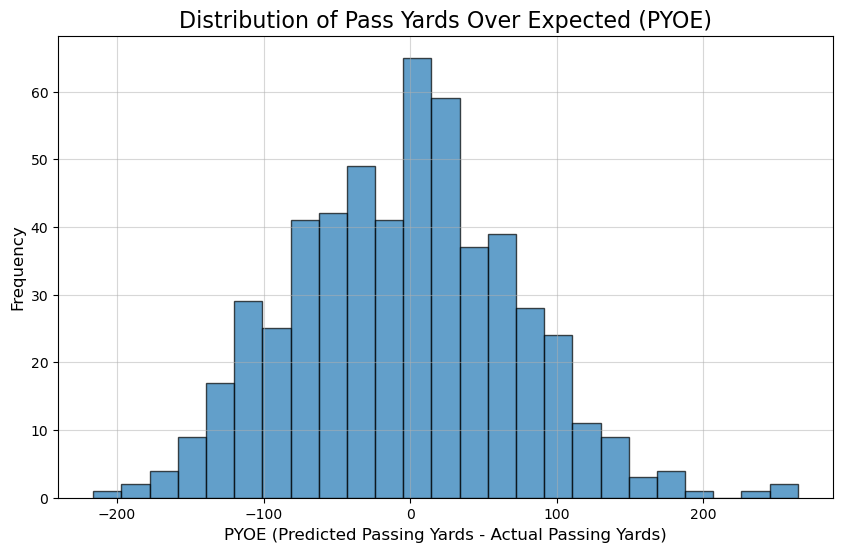

In [ ]:
# Plotting the histogram of PYOE
plt.figure(figsize=(10, 6))
plt.hist(test_data['pyoe'], bins=25, edgecolor='black', alpha=0.7)
plt.title('Distribution of Pass Yards Over Expected (PYOE)', fontsize=16)
plt.xlabel('PYOE (Predicted Passing Yards - Actual Passing Yards)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

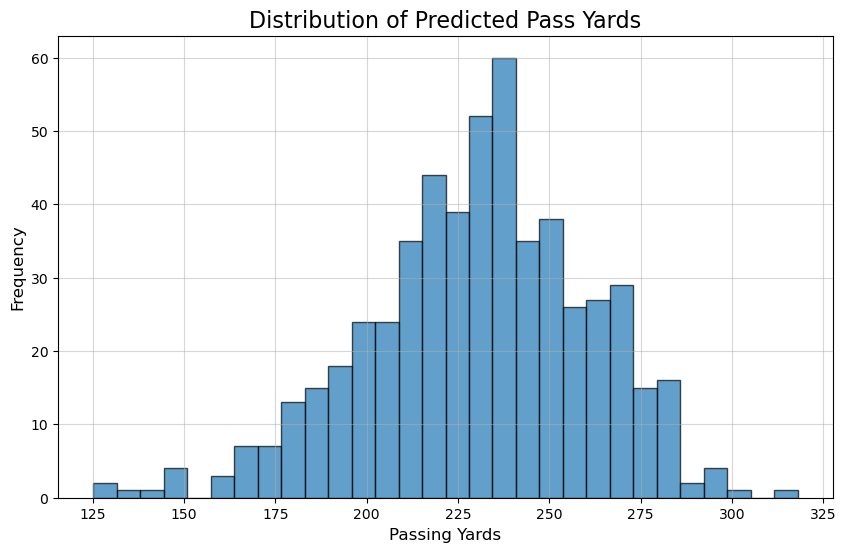

In [ ]:
# Plotting the histogram of PYOE
plt.figure(figsize=(10, 6))
plt.hist(test_data['predicted_passing_yards'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Predicted Pass Yards', fontsize=16)
plt.xlabel('Passing Yards', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

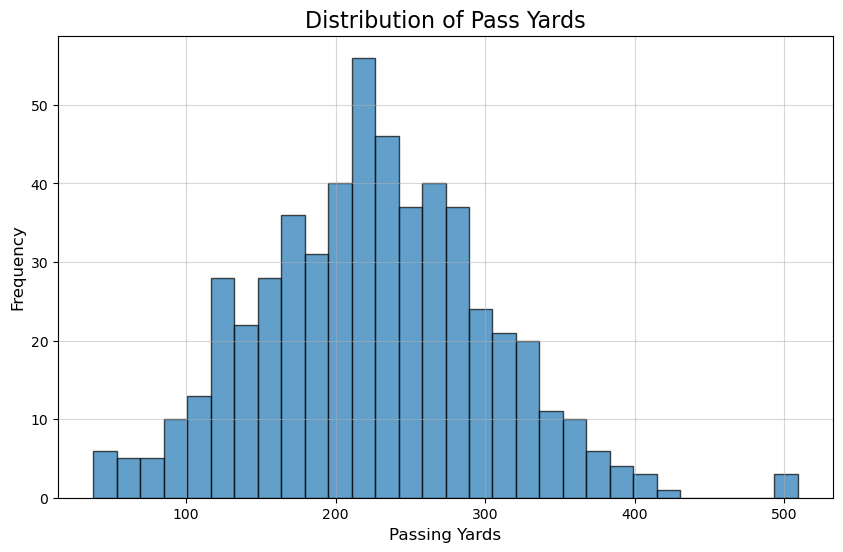

In [ ]:
# Plotting the histogram of Pass Yards
plt.figure(figsize=(10, 6))
plt.hist(test_data['passing_yards'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Pass Yards', fontsize=16)
plt.xlabel('Passing Yards', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

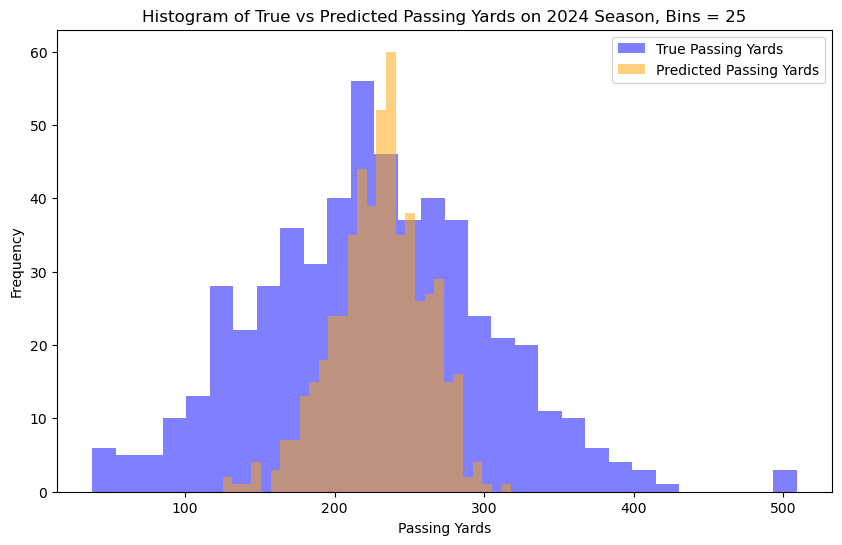

In [ ]:
# Plotting the histogram of predicted passing yards and true passing yards
plt.figure(figsize=(10, 6))

# Plot histogram for true passing yards
plt.hist(test_data['passing_yards'], bins=30, alpha=0.5, label='True Passing Yards', color='blue')

# Plot histogram for predicted passing yards
plt.hist(test_data['predicted_passing_yards'], bins=30, alpha=0.5, label='Predicted Passing Yards', color='orange')

# Adding labels and title
plt.xlabel('Passing Yards')
plt.ylabel('Frequency')
plt.title('Histogram of True vs Predicted Passing Yards on 2024 Season, Bins = 25')
plt.legend(loc='upper right')

# Show the plot
plt.show()

below checks a qb's simulator prediction with a bootstrapped curve that is custom to that team's own passing variance this year. rad

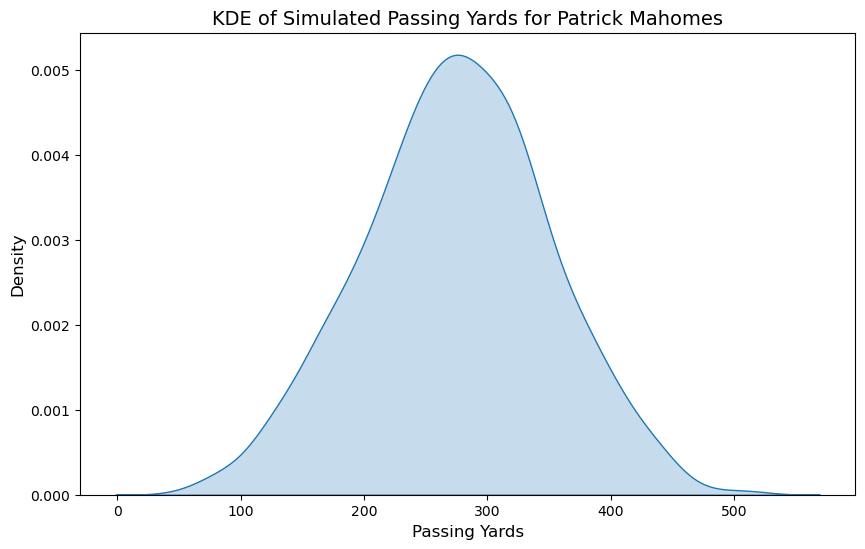

In [ ]:
# Example: Visualize Some QB's simulated passing yard

#Put a starting QB In here to view the bootstrapped dist monte carlo simulation output
simulations = qb_simulations['Patrick Mahomes']

# Example: Visualize Kyler Murray's simulated passing yards using KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(simulations, fill=True)

# Add titles and labels
plt.title("KDE of Simulated Passing Yards for Patrick Mahomes", fontsize=14)
plt.xlabel("Passing Yards", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Show the plot

plt.show()

## To do:
* Figure out wtm is when there is a new qb/injury
* Find a way to tone down overpredictions (seems to be a weird trend this season people passing for less yards)
* Week 1 stuff for next season
* Write predictions to some sort of database for front end use? (ask pals with better knowledge on usable coding skills)